In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Agent-LangGraph-Test")

LangSmith 추적을 시작합니다.
[프로젝트명]
Agent-LangGraph-Test


In [15]:
import operator
from typing import TypedDict, List, Dict, Any, Optional, Annotated, Literal
from typing_extensions import Annotated
from pydantic import BaseModel

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import START, END
from langgraph.graph import StateGraph
from langchain.agents import create_tool_calling_agent, create_react_agent, AgentExecutor
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_experimental.tools import PythonREPLTool
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import random_uuid, invoke_graph
from langchain_teddynote.models import get_model_name, LLMs

from agent_config import AgentConfig
from data import DBManager

from utils import *
from prompts_langgraph import Prompt

import os
os.environ["PYDANTIC_STRICT_SCHEMA_VALIDATION"] = "False"


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)


gpt-4o


In [4]:
conf = AgentConfig()
dbm = DBManager(conf)
db = dbm.get_db_connection()

# 도구 생성

## DB Team 도구

In [5]:
@tool
def select_table(question: str) -> str:
    """
    사용자 쿼리를 기반으로 데이터베이스에서 관련 테이블을 선택합니다.
    """

    AVAILABLE_TABLES = f"""
        "TB_{conf.algorithm_code}_RT": "실시간 측정 데이터 테이블. 센서의 실시간 측정값을 저장합니다.",
        "TB_AI_{conf.algorithm_code}_RT": "AI 분석 결과 테이블. AI가 분석한 예측값과 결과를 저장합니다.",
        "TB_AI_{conf.algorithm_code}_CTR": "AI 제어 결과 테이블. AI의 제어 명령과 결과를 저장합니다.",
        "TB_AI_{conf.algorithm_code}_ALM": "AI 경고 테이블. AI운영 도중 발생한 알람 메시지를 저장합니다.",
        "TB_AI_{conf.algorithm_code}_INIT": "AI 알고리즘의 초기 설정 테이블. 상한, 하한 및 초기 설정 값을 저장",
        "TB_TAG_MNG": "태그 관리 테이블. 시스템에서 사용하는 태그(센서 등)의 메타데이터를 저장합니다."
    """

    # 프롬프트 작성
    table_selection_prompt = Prompt().table_selection_prompt()

    # LLM 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

    # chain 생성
    select_table_chain = table_selection_prompt | llm | StrOutputParser()
    response = select_table_chain.invoke({
                                            "question": question,
                                            "available_tables": AVAILABLE_TABLES
                                        })
    
    return json_parse(response)


@tool
def generate_sql_query(
        question: str,
        table_dict: Annotated[List[str], select_table],
) -> Dict[str, str]:
    """    
    사용자의 자연어 쿼리를 분석하여 지정된 테이블에 대한 SQL 문을 생성하고, 
    테이블 이름과 해당 테이블에 대한 SQL 문을 반환합니다.
    """
    TABLE_SCHEMAS = {
            table: db.get_table_info([table]) for table in table_dict.keys()
        }
    schema_info = ""
    for table, schema in TABLE_SCHEMAS.items():
        schema_info += f"\n## {table} Table:\n{process_schema_for_prompt(schema)}\n"
    
    # LLM 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    sql_query_generation_prompt = Prompt().sql_query_generation_prompt()
    sql_query_generator_chain = sql_query_generation_prompt | llm | StrOutputParser()

    query_dict = {}
    for table_name in table_dict.keys():
        sql_query = sql_query_generator_chain.invoke({
                    "schema_info": schema_info,
                    "question": question,
                    "table_name": table_name
                })
        query_dict[table_name] = sql_query

    return query_dict

@tool
def load_data(
        table_name: str,
        query_dict: Annotated[dict, generate_sql_query]
):
    """
    테이블 이름을 입력하면 테이블의 데이터를 불러옵니다.
    """
    return table_name, dbm.select_from_table(query_dict[table_name])

@tool
def convert_df(table_name: str, df: pd.DataFrame):
    """
    테이블 이름에 따라 데이터 프레임을 변환합니다.
    """
    if table_name == 'TB_AI_{conf.algorithm_code}_RT':
        df = process_ai_rt(df)
    else:
        df = df.map(convert_value)

    return df


# PythonREPL 도구
python_repl_tool = PythonREPLTool()

##  RAG Team 도구

In [6]:
@tool
def rag_tool():
    "RAG 에이전트 구현을 위한 임시 도구"

    return

# 다중 에이전트 생성을 위한 유틸리티 함수 정의

In [7]:
# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node
    
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

agent_factory = AgentFactory(MODEL_NAME)


# 에이전트 및 노드 생성 예시
# agent = create_react_agent(llm, tools=[], state_modifier=state_modifier)
# node = agent_factory.create_agent_node(agent, "DB Team")

In [8]:
def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

In [9]:
# 다음으로 라우팅할 노드 선택
def get_next_node(x):
    return x["next"]




In [10]:
def run_graph(app, message: str, recursive_limit: int = 50):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
        # "question": message
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values


# 에이전트 팀 정의

## DB Team

In [21]:
class DBState(TypedDict, total=False):
    """상태 관리를 위한 TypedDict 클래스"""
    
    # 기본 필드 (필수)
    messages: Annotated[List[BaseMessage], operator.add]  # 대화 히스토리
    agent_scratchpad: List[BaseMessage]  # 에이전트 작업 공간
    
    # 라우팅 필드 (필수)
    next: str  # 다음 실행할 노드 이름
    
    # 노드별 처리 결과
    selected_tables: Dict[str, str]  # TableSelector 결과: {"테이블명": "선택 이유"}
    generated_queries: Dict[str, str]  # QueryGenerator 결과: {"테이블명": "SQL 쿼리"}
    processed_data: Any  # DataProcessor 결과: 처리된 데이터
    
    # 상태 관리 필드
    status: str  # 현재 상태 ("completed", "error" 등)
    error: Optional[Dict[str, Any]]  # 에러 정보 저장
    
    # 중간 처리 단계 기록
    intermediate_steps: List[Dict[str, Any]]  # 각 노드의 중간 처리 단계

In [26]:
def get_next_node(state: DBState) -> str:
    # 에러 체크
    if state.get("error"):
        return "FINISH"
    
    # 현재 상태 체크
    current = state.get("current_node", "start")
    
    if current == "start":
        return "TableSelector"
    elif current == "TableSelector" and state.get("selected_tables"):
        return "QueryGenerator"
    elif current == "QueryGenerator" and state.get("generated_queries"):
        return "DataProcessor"
    elif current == "DataProcessor" and state.get("status") == "completed":
        return "FINISH"
    
    # 기본값
    return state.get("next", "FINISH")

### 노드 생성

In [22]:
# TableSelector 노드
def table_selector_node(state: DBState):
    """
    테이블 선택 노드: 사용자 쿼리를 분석하여 관련된 데이터베이스 테이블을 선택합니다.
    
    Args:
        state (DBState): 현재 상태 객체. 다음을 포함해야 합니다:
            - messages: 대화 히스토리
            - agent_scratchpad: 에이전트 작업 공간
    
    Returns:
        Dict: 업데이트된 상태. 다음 필드가 추가/수정됩니다:
            - messages: 테이블 선택 결과가 추가된 대화 히스토리
            - selected_tables: 선택된 테이블 정보
            - agent_scratchpad: 업데이트된 작업 공간
    """
    # 입력 준비
    question = state["messages"][0].content if state["messages"] else ""

    # 프롬프트 생성
    table_selector_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", 
            "You are a database table selector specialized in water management systems."
            "Your role is to analyze user queries and select the most relevant tables for data retrieval."
            "Using the following tools, select the most relevant tables to answer the user request."            
            "You have access to the following tools: {tools}"
            "The available tools are: {tool_names}"
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    
    # 에이전트 생성
    table_selector_agent = create_react_agent(llm, tools=[select_table], prompt=table_selector_prompt)
    table_selector_agent_executor = AgentExecutor(
                                        agent=table_selector_agent, 
                                        tools=[select_table],
                                        handle_parsing_errors=True,
                                        verbose=True
                                    )

    # 에이전트 실행
    result = table_selector_agent_executor.invoke({
                "messages": state["messages"],
                "agent_scratchpad": state.get("agent_scratchpad", []),
                "question": question,
                "tools": [select_table],
                "tool_names": ["select_table"]
            })
    
    return {
        **state,
        "messages": state["messages"] + [
            HumanMessage(content=result["output"], name="TableSelector")
        ],
        "selected_tables": json_parse(result["output"]),
        "agent_scratchpad": result.get("intermediate_steps", [])
    }


def query_generator_node(state: DBState):
    """
    데이터 처리 노드: 생성된 쿼리를 실행하고 결과를 처리합니다.
    
    Args:
        state (DBState): 현재 상태 객체. 다음을 포함해야 합니다:
            - messages: 대화 히스토리
            - generated_queries: QueryGenerator에서 생성한 SQL 쿼리
            - agent_scratchpad: 에이전트 작업 공간
    
    Returns:
        Dict: 업데이트된 상태. 다음 필드가 추가/수정됩니다:
            - messages: 데이터 처리 결과가 추가된 대화 히스토리
            - query_results: 쿼리 실행 결과
            - agent_scratchpad: 업데이트된 작업 공간
    """
    # 입력 준비
    question = state["messages"][0].content if state["messages"] else ""
    selected_tables = state["selected_tables"]
    
    # 프롬프트 생성
    query_generator_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", 
            "You are a SQL query generator specialized in water management systems."
            "Your role is to analyze user queries and generate the most relevant SQL queries to retrieve data from the database."
            "Using the following tools, generate the most relevant SQL queries to answer the user request."            
            "You have access to the following tools: {tools}"
            "The available tools are: {tool_names}"
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    
    # 에이전트 생성
    query_generator_agent = create_react_agent(llm, tools=[generate_sql_query], prompt=query_generator_prompt)
    query_generator_agent_executor = AgentExecutor(
        agent=query_generator_agent, 
        tools=[generate_sql_query],
        handle_parsing_errors=True,
        verbose=True
    )
    
    # 에이전트 실행
    result = query_generator_agent_executor.invoke({
        "messages": state["messages"],
        "agent_scratchpad": state.get("agent_scratchpad", []),
        "question": question,
        "selected_tables": selected_tables,  # 이 부분 추가 필요
        "tools": [generate_sql_query],
        "tool_names": ["generate_sql_query"]
    })
    
    return {
        **state,
        "messages": state["messages"] + [
            HumanMessage(content=result["output"], name="QueryGenerator")
        ],
        "generated_queries": json_parse(result["output"]),
        "agent_scratchpad": result.get("intermediate_steps", [])
    }


def data_processor_node(state: DBState):
    """
    데이터 처리 노드: 생성된 쿼리를 실행하고 결과를 처리합니다.
    
    Args:
        state (DBState): 현재 상태 객체. 다음을 포함해야 합니다:
            - messages: 대화 히스토리
            - query_results: QueryGenerator에서 생성한 SQL 쿼리 결과
            - agent_scratchpad: 에이전트 작업 공간
    
    Returns:
        Dict: 업데이트된 상태. 다음 필드가 추가/수정됩니다:
            - messages: 데이터 처리 결과가 추가된 대화 히스토리
            - query_results: 쿼리 실행 결과
            - agent_scratchpad: 업데이트된 작업 공간
    """
    # 입력 준비
    question = state["messages"][0].content if state["messages"] else ""
    generated_queries = state["generated_queries"]

    # 프롬프트 생성
    data_processor_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", 
            """
            You are a professional data analyst and expert in Pandas.
            You must use Pandas DataFrame(`df`) to answer user's request.
            

            Using the following tools, process the results of the SQL queries to answer the user request.
            - load_data: If you input a table name and query_dict, the tool will load the data from the database.
            - convert_df: If you input a table name and df, the tool will convert the data to a proper format.
            - python_repl_tool: It is a tool that can execute Python code.

            [IMPORTANT] DO NOT create or overwrite the `df` variable in your code.

            <Visualization Preference>
            You don't need to generate visualization code.
            When creating visualizations, ALWAYS include `plt.show()` at the end of your code.
            I prefer seaborn code for visualization, but you can use matplotlib as well.
            Use `Korean` for your visualization title and labels.

            ### Column Guidelines
            - If user asks with columns that are not listed in `df.columns`, you may refer to the most similar columns listed below.
            - If the dataframe has a multiple columns after converting,
              it would be better to use df.loc[:, df.columns.get_level_values(COLUMNS_LEVEL_NAME) == COLUMN_NAME] when you select certain columns.

            Please final answer in `Korean`.
            """
            ),
            MessagesPlaceholder(variable_name="messages"),
            # ("placeholder", "{chat_history}"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    # 에이전트 생성
    data_processor_agent = create_react_agent(llm, tools=[load_data, convert_df, python_repl_tool], prompt=data_processor_prompt)
    data_processor_agent_executor = AgentExecutor(
                                        agent=data_processor_agent, 
                                        tools=[load_data, convert_df, python_repl_tool],
                                        handle_parsing_errors=True,  # 에러 처리 추가
                                        verbose=True  # 디버깅을 위한 verbose 추가
                                    )
    
    # 에이전트 실행
    result = data_processor_agent_executor.invoke({
        "messages": state["messages"],
        "agent_scratchpad": state.get("agent_scratchpad", []),
        "question": question,
        "generated_queries": generated_queries,  # 이 부분 추가
        "tools": [load_data, convert_df, python_repl_tool],
        "tool_names": ["load_data", "convert_df", "python_repl_tool"]
    })
    
    return {
        **state,
        "messages": state["messages"] + [
            HumanMessage(content=result["output"], name="DataProcessor")
        ],
        "agent_scratchpad": result.get("intermediate_steps", []),
        "processed_data": result.get("output"),  # 처리된 데이터 저장
        "error": result.get("error"),  # 에러 정보 저장 (있는 경우)
        "status": "completed"  # 상태 표시
    }

In [23]:

# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 노드 생성
# table_selector_agent = create_react_agent(llm, tools=[select_table], prompt=table_selector_prompt)
# table_selector_agent_executor = AgentExecutor(agent=table_selector_agent, tools=[select_table])
# table_selector_node = agent_factory.create_agent_node(table_selector_agent_executor, "TableSelector")

# query_generator_agent = create_react_agent(llm, tools=[generate_sql_query], prompt=query_generator_prompt)
# query_generator_agent_executor = AgentExecutor(agent=query_generator_agent, tools=[generate_sql_query])
# query_generator_node = agent_factory.create_agent_node(query_generator_agent_executor, "QueryGenerator")


# data_processor_agent = create_react_agent(llm, tools=[load_data, convert_df, python_repl_tool], prompt=data_processor_prompt)
# data_processor_agent_executor = AgentExecutor(agent=data_processor_agent, tools=[load_data, convert_df, python_repl_tool])
# data_processor_node = agent_factory.create_agent_node(data_processor_agent_executor, "DataProcessor")

# Supervisor 에이전트 생성
db_supervisor_agent = create_team_supervisor(
    model_name=MODEL_NAME,
    system_prompt="You are a supervisor tasked with managing a conversation between the"
    " following workers: TableSelector, QueryGenerator, PythonExecutor. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    members=["TableSelector", "QueryGenerator", "DataProcessor"]
)


### DB Team 그래프 생성

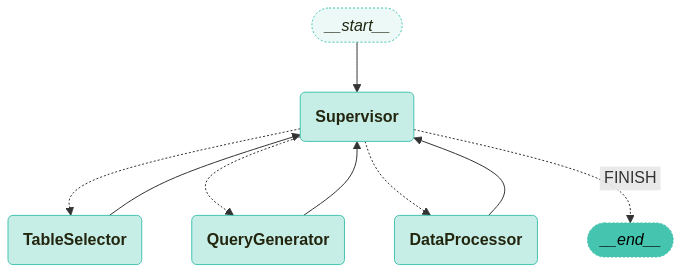

In [24]:
# 그래프 생성
db_graph = StateGraph(DBState)

# 노드 추가
db_graph.add_node("TableSelector", table_selector_node)
db_graph.add_node("QueryGenerator", query_generator_node)
db_graph.add_node("DataProcessor", data_processor_node)
db_graph.add_node("Supervisor", db_supervisor_agent)

# 엣지 추가
db_graph.add_edge("TableSelector", "Supervisor")
db_graph.add_edge("QueryGenerator", "Supervisor")
db_graph.add_edge("DataProcessor", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
db_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "TableSelector": "TableSelector",
        "QueryGenerator": "QueryGenerator",
        "DataProcessor": "DataProcessor",
        "FINISH": END
    }
)

# 시작 노드 설정
db_graph.set_entry_point("Supervisor")

# 그래프 컴파일
db_graph_app = db_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(db_graph_app, xray=True)


In [25]:
from uuid import uuid4

config = RunnableConfig(
    recursion_limit=50,  # 최대 재귀 횟수 제한
    configurable={"thread_id": str(uuid4())}  # 고유 스레드 ID 생성
)

# 초기 상태 생성
initial_state = {
    "messages": [HumanMessage(content="3월 10일부터 11일까지 원수 탁도의 추이를 보여줘")],
    "question": "3월 10일부터 11일까지 원수 탁도의 추이를 보여줘",  # 반드시 필요
    "team_members": ["TableSelector", "QueryGenerator", "DataProcessor"],
    "next": "TableSelector"  # 시작 노드 지정
}

# 그래프 직접 실행
result = db_graph_app.invoke(initial_state, config)

Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.St



> Entering new AgentExecutor chain...


ValueError: variable agent_scratchpad should be a list of base messages, got  of type <class 'str'>

In [19]:
db_graph_app

In [20]:
output = run_graph(
    db_graph_app,
    "3월 10일부터 11일까지 원수 탁도의 추이를 보여줘",
)

KeyError: 'next'

## RAG Team

In [17]:
# 상태 정의
class RAGState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # 메시지
    team_members: List[str]  # 멤버 에이전트 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시

# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# prompt 생성
rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", 
        "You are a database explorer."
        "You are given a user request and a list of tables."
        "You have access to the following tools: {tools}"
        "The available tools are: {tool_names}"
        "You need to select the most relevant table and generate a SQL query to answer the user request."
        ),
        MessagesPlaceholder(variable_name="messages"),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)



# 노드 생성
operation_log_agent = create_react_agent(llm, tools=[rag_tool], prompt=rag_prompt)
operation_log_agent_executor = AgentExecutor(agent=operation_log_agent, tools=[rag_tool])
operation_log_node = agent_factory.create_agent_node(operation_log_agent_executor, "OperationLog")

plant_info_agent = create_react_agent(llm, tools=[rag_tool], prompt=rag_prompt)
plant_info_agent_executor = AgentExecutor(agent=plant_info_agent, tools=[rag_tool])
plant_info_node = agent_factory.create_agent_node(plant_info_agent_executor, "PlantInfo")

dev_docs_agent = create_react_agent(llm, tools=[rag_tool], prompt=rag_prompt)
dev_docs_agent_executor = AgentExecutor(agent=dev_docs_agent, tools=[rag_tool])
dev_docs_agent = agent_factory.create_agent_node(dev_docs_agent_executor, "DevDocs")



# Supervisor 에이전트 생성
rag_supervisor_agent = create_team_supervisor(
    model_name=MODEL_NAME,
    system_prompt="You are a supervisor tasked with managing a conversation between the"
    " following workers: DBExplorer, PythonExecutor. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    members=["OperationLog", "PlantInfo", "DevDocs"]
)


### RAG 팀 그래프 생성

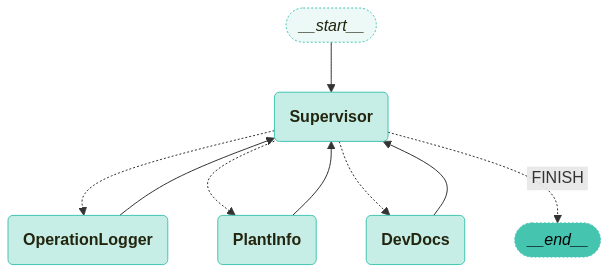

In [18]:
# 그래프 생성
rag_graph = StateGraph(RAGState)

# 노드 추가
rag_graph.add_node("OperationLogger", operation_log_node)
rag_graph.add_node("PlantInfo", plant_info_node)
rag_graph.add_node("DevDocs", dev_docs_agent)
rag_graph.add_node("Supervisor", rag_supervisor_agent)

# 엣지 추가
rag_graph.add_edge("OperationLogger", "Supervisor")
rag_graph.add_edge("PlantInfo", "Supervisor")
rag_graph.add_edge("DevDocs", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
rag_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "OperationLogger": "OperationLogger",
        "PlantInfo": "PlantInfo",
        "DevDocs": "DevDocs",
        "FINISH": END
    }
)

# 시작 노드 설정
rag_graph.set_entry_point("Supervisor")

# 그래프 컴파일
rag_graph_app = rag_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(rag_graph_app, xray=True)


# Super Graph 생성

In [19]:
# 기본 LLM으로 ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model=MODEL_NAME)

# 팀 감독자 노드 생성
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['DBTeam', 'RAGTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DBTeam", "RAGTeam"],
)

In [20]:
# 상태 정의
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # 라우팅 결정
    next: str


# 마지막 메시지 반환 노드
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# 응답 종합 노드
def join_graph(response: dict):
    # 마지막 메시지를 추출하여 메시지 목록으로 반환
    return {"messages": [response["messages"][-1]]}

## Super Graph 정의

In [21]:
# 그래프 정의
super_graph = StateGraph(State)

# 노드 정의
super_graph.add_node("DBTeam", get_last_message | db_graph_app | join_graph)
super_graph.add_node("RAGTeam", get_last_message | rag_graph_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# 엣지 정의
super_graph.add_edge("DBTeam", "Supervisor")
super_graph.add_edge("RAGTeam", "Supervisor")

# 조건부 엣지 추가: Supervisor 의 결정에 따라 다음 노드로 이동
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DBTeam": "DBTeam",
        "RAGTeam": "RAGTeam",
        "FINISH": END,
    },
)

# Supervisor 노드를 시작 노드로 설정
super_graph.set_entry_point("Supervisor")

# 그래프 컴파일
super_graph = super_graph.compile(checkpointer=MemorySaver())


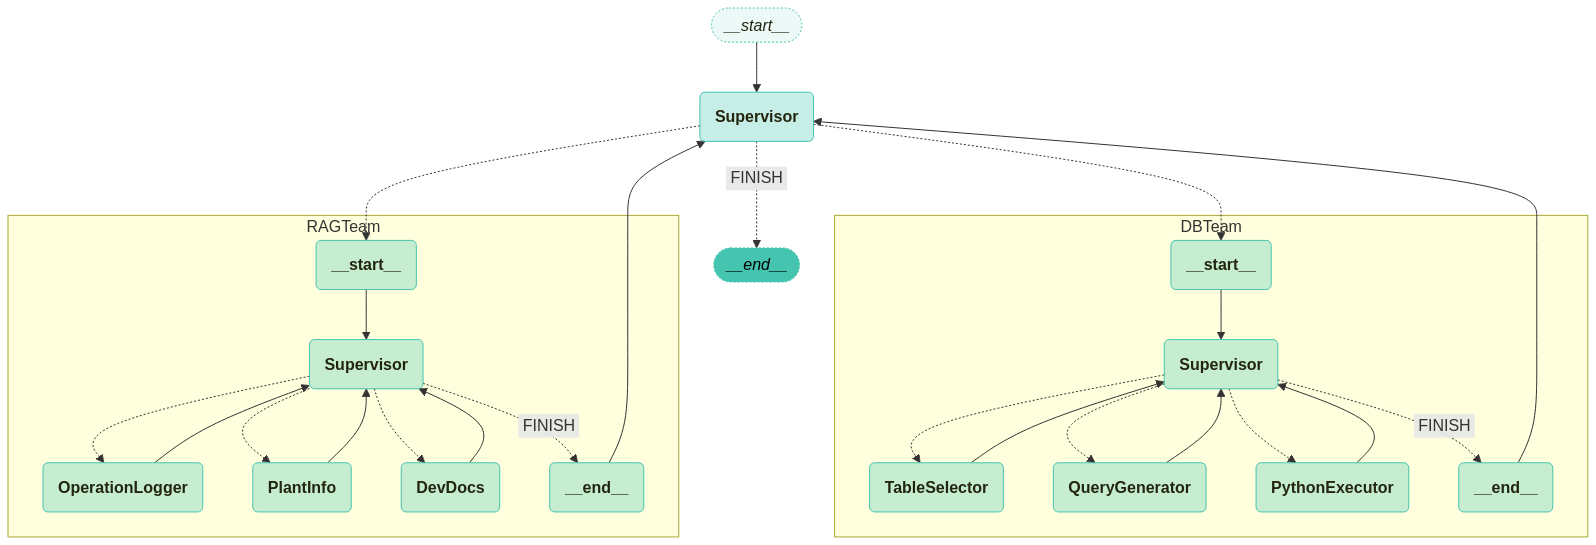

In [22]:
visualize_graph(super_graph, xray=True)
